# Ethics, Fairness and Explanation in AI Coursework

Your goal in this coursework is to implement and experiment with various explainability approaches in order to better understand the behaviour of a neural model applied to the Titanic dataset. As you will have a chance to observe, the dataset reflects some of the past social conventions and biases, which also affect the trained model. Explanations can serve as very useful tools for identifying such potential issues and gaining insight into the internal reasoning of machine learning systems.

##NOTE FOR MARKER: if code produces error, please restart the session and run the cell again to use the installed versions.

## Data Loading and Preprocessing

We start by defining some helpful utility functions for data preprocessing. You will probably not need to change this code.

In [1]:
!pip install arrow==1.3.0
!pip install captum==0.7.0
!pip install ipykernel==6.29.0
!pip install ipython==8.21.0
!pip install ipywidgets==8.1.1
!pip install jupyter-events==0.9.0
!pip install jupyter-lsp==2.2.2
!pip install jupyter_client==8.6.0
!pip install jupyter_core==5.7.1
!pip install jupyter_server==2.12.5
!pip install jupyter_server_terminals==0.5.2
!pip install jupyterlab==4.0.12
!pip install jupyterlab-widgets==3.0.9
!pip install jupyterlab_pygments==0.3.0
!pip install jupyterlab_server==2.25.2
!pip install matplotlib==3.8.2
!pip install matplotlib-inline==0.1.6
!pip install numpy==1.26.3
!pip install pandas==2.2.0
!pip install pyarrow==15.0.0
!pip install scikit-learn==1.4.0
!pip install scipy==1.12.0
!pip install seaborn==0.13.2
!pip install tabulate==0.9.0
!pip install torch==2.2.0
!pip install torcheval==0.0.7
!pip install tqdm==4.66.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 8.5 MB/s eta 0:00:00
  Using cached torch-2.2.0-cp310-cp310-manylinux1_x86_64.whl (755.5 MB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64

In [2]:
#!pip install torch==2.2.0+cu113 torchvision==0.13.0+cu113 torchaudio==0.12.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

import numpy as np
import pandas as pd
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.utils import resample


class InvertibleColumnTransformer(ColumnTransformer):
    """
    This is an invertible version of a ColumnTransformer from sklearn.
    This allows us to recover the original feature values from their normalised
    versions in order to better understand the produced explanations.
    """
    def inverse_transform(self, X):
        if X.ndim == 1:
            X = np.expand_dims(X, axis=0)
        if X.shape[1] != len(self.get_feature_names_out()):
            raise ValueError(
                "X and the fitted transformer have different numbers of columns"
            )

        inverted_X_base = np.zeros((X.shape[0], self.n_features_in_))
        columns = [c for cs in self._columns for c in cs]
        inverted_X = pd.DataFrame(data=inverted_X_base, columns=columns)
        inverted_X = inverted_X.astype('object')
        for name, indices in self.output_indices_.items():
            transformer = self.named_transformers_.get(name, None)
            if transformer is None:
                continue

            selected_X = X[:, indices.start : indices.stop]
            if isinstance(transformer, OneHotEncoder):
                # Assumed only one column changing encoder at the end
                categories = transformer.inverse_transform(selected_X)
                inverted_X.loc[
                    :, columns[indices.start : indices.start + len(categories[0])]
                ] = categories
            else:
                # Assumed scaler-type transformer
                inverted_X.loc[
                    :, [columns[i] for i in range(indices.start, indices.stop)]
                ] = transformer.inverse_transform(selected_X)

        return inverted_X


def preprocess_train_data(
    df,
    scaled_features=None,
    categorical_features=None,
    scaler=RobustScaler(quantile_range=(10, 90)),
    categorical_encoder=OneHotEncoder(handle_unknown="ignore"),
):
    """
    Scales the continuous features using a RobustScaler and one-hot encodes
    the categorical features.
    """
    if scaled_features is None and categorical_features is None:
        warnings.warn("No features specified for preprocessing, using raw data.")
        scaled_features = []
        categorical_features = []
    elif scaled_features is None:
        scaled_features = [c for c in df.columns if c not in categorical_features]
    elif categorical_features is None:
        categorical_features = [c for c in df.columns if c not in scaled_features]

    preprocessor = InvertibleColumnTransformer(
        transformers=[
            ("num", scaler, scaled_features),
            ("cat", categorical_encoder, categorical_features),
        ],
        remainder="passthrough",
    )

    preprocessed_df = preprocessor.fit_transform(df)
    return preprocessed_df, preprocessor


def preprocess_test_data(df, preprocessor):
    preprocessed_df = preprocessor.transform(df)
    return preprocessed_df

Here, we define a class for the Titanic dataset, which we will be using throughout the coursework.

In [3]:
import os
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


class TitanicDataset(Dataset):
    """
    Loads and preprocesses the Titanic dataset.
    """
    __create_key = object()

    @classmethod
    def create_datasets(
        cls,
        label_name="survived",
        split_seed=42,
        test_size=0.2,
    ):
        train_dataset = TitanicDataset(
            cls.__create_key,
            label_name=label_name,
            split_seed=split_seed,
            test_size=test_size,
            train=True,
        )
        test_dataset = TitanicDataset(
            cls.__create_key,
            label_name=label_name,
            split_seed=split_seed,
            test_size=test_size,
            train=False,
        )
        return train_dataset, test_dataset

    def __init__(
        self,
        create_key=None,
        label_name="Survived",
        split_seed=42,
        test_size=0.2,
        train=True,
    ):
        # Ensure that the dataset is being constructed properly
        if create_key != TitanicDataset.__create_key:
            raise ValueError(
                "Illegal initialisation attempt — please use create_datasets to initialise."
            )

        try:
            data_df = pd.read_csv("drive/MyDrive/Ethics/titanic-dataset.csv")
        except FileNotFoundError:
            raise FileNotFoundError("Titanic data file not found.")

        # Split the dataset into train and test
        x = data_df.drop(columns=[label_name, "name", "ticket", "cabin", "embarked", "boat", "body", "home.dest"])
        # For the purposes of this coursework, we just impute the missing age and fare with a median value
        x[['age']] = x[['age']].fillna(x[['age']].median())
        x[['fare']] = x[['fare']].fillna(x[['fare']].median())
        y = data_df[label_name]
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=test_size, random_state=split_seed, shuffle=True
        )
        if train:
            self.raw_data = x_train, y_train
        else:
            self.raw_data = x_test, y_test

        # Preprocess the data
        x_train_processed, preprocessor = preprocess_train_data(
            x_train, categorical_features=["sex"]
        )
        x_train = pd.DataFrame(
            x_train_processed, columns=preprocessor.get_feature_names_out()
        )
        x_test_processed = preprocess_test_data(x_test, preprocessor)
        x_test = pd.DataFrame(
            x_test_processed, columns=preprocessor.get_feature_names_out()
        )

        # Select data partition and convert to tensors
        if train:
            samples = x_train
            labels = y_train
        else:
            samples = x_test
            labels = y_test
        self.samples = torch.tensor(samples.to_numpy(), dtype=torch.float32)
        self.labels = torch.tensor(labels.to_numpy(), dtype=torch.long)
        self.features = preprocessor.get_feature_names_out()
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

Finally, we call the code above to load and preprocess the data.

In [4]:
from google.colab import drive
drive.mount('drive/')

Mounted at drive/


In [5]:
train_dataset, test_dataset = TitanicDataset.create_datasets(
    test_size=0.2,
    split_seed=42,
)
train_dl = DataLoader(
    dataset=train_dataset,
    batch_size=128,
    shuffle=False,
)
test_dl = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

Note that the invertible transformer allows you to recover the original (unnormalised) feature values, as shown on the example below. You may find this helpful for understanding the produced explanations and commenting on them in your report.

In [6]:
test_dataset.preprocessor.inverse_transform(test_dataset.samples[0])

,pclass,age,sibsp,parch,fare,sex
0,3.0,35.0,0.0,0.0,7.125,male


## Exploratory Data Analysis

When faced with a new dataset, it is a good practice to perform an exploratory data analysis in order to understand the basic trends in the data. This will also allow you to put the explanations you obtain as part of this coursework into the relevant context. We will use the raw, unnormalised features for this purpose, as they are much more intuitive and human-understandable.

In [7]:
x_train, y_train = train_dataset.raw_data
x_train['survived'] = y_train
data_df = x_train

We start by displaying the feature values and labels for a few samples. The dataset contains data regarding the survival of some of the passengers involved in the [Titanic maritime disaster](https://en.wikipedia.org/wiki/Sinking_of_the_Titanic). The features contained in the data are as follows:
* `pclass`: Indicates the travelling class of the given passenger. Note that we treat this feature as numerical, as the different classes introduce a natural order.
* `sex`: Indicates the sex of the passenger.
* `age`: Provides the age of the passenger.
* `sibsp`: Denotes the total number of siblings and spouses of the given passenger also travelling on RMS Titanic.
* `parch`: Denotes the total number of parents or children of the given passenger also travelling on RMS Titanic.
* `fare`: Indicates the fare paid by the passenger for the journey.
* `survived`: The label indicating whether the patient survived the accident (1 = survived, 0 = did not survive).

There are other features included in the original dataset (such aspassenger name or point of embarkation), but we choose to ignore them for the purposes of this coursework.

In [ ]:
data_df

,pclass,sex,age,sibsp,parch,fare,survived
772,3,male,17.0,0,0,7.8958,0
543,2,male,36.0,0,0,10.5000,0
289,1,female,18.0,0,2,79.6500,1
10,1,male,47.0,1,0,227.5250,0
147,1,male,28.0,0,0,42.4000,0
...,...,...,...,...,...,...,...
1095,3,female,28.0,0,0,7.6292,0
1130,3,female,18.0,0,0,7.7750,0
1294,3,male,28.5,0,0,16.1000,0
860,3,female,26.0,0,0,7.9250,1





Let us visualise the correlation between the individual columns of the data, computed using the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient). Note that we excluded the `sex` feature from this visualisation, as it is categorical.

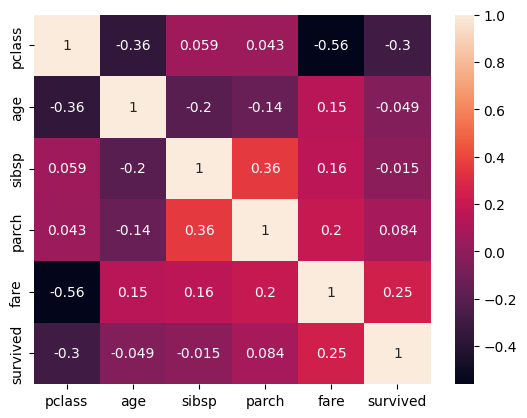

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = data_df.drop(columns=["sex"]).corr()
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    fmt='.2g',
)
plt.show()

Since the previous plot does not include the categorical `sex` column, we also separately visualise its distribution, including the associated labels.

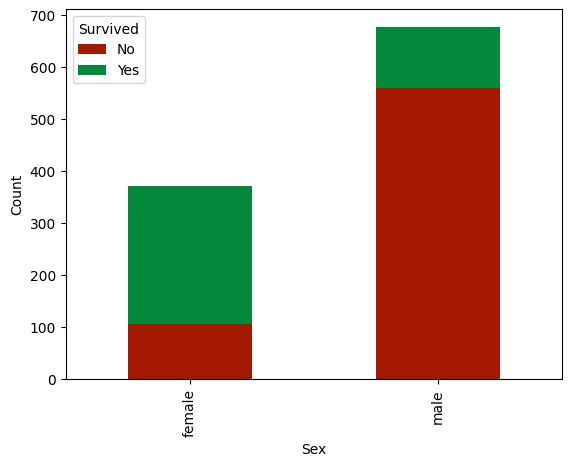

In [ ]:
data_df.groupby(['sex', 'survived']).size().unstack().plot(
    kind='bar', stacked=True, color=['#a51900', '#02893b'], xlabel="Sex", ylabel="Count"
)
plt.legend(['No', 'Yes'], title="Survived")
plt.show()

**Task 1(a)**: <br />
**(i) Considering the above visualisations, are there any trends or patterns that you can identify in the data?** <br />

Exploratory data analysis highlights a negative correlation between 'Pclass' and 'Survived', showing that passengers of higher socio-economic status were more likely to survive, aligning with historical records of better lifeboat access for higher-class passengers. The correlation between 'Pclass' and 'Fare' reaffirms that higher-class tickets cost more. The association between family size ('SibSp'/'Parch') and survival is less clear, suggesting it was not a major survival determinant. The sex distribution plot starkly shows higher survival rates for females, consistent with the "women and children first" evacuation protocol observed on the Titanic.

**(ii)** Without having access to any particular model or the associated explanations, which features would you expect to be the most and least important for a neural network trained on the dataset? How can you tell and how certain can you be of your assessment?

Based on observed survival rates, historical importance of class and gender and without a specific model, 'Sex' and 'PClass' could have high correlation with survival. 'Fare' might influence predictions since it relates to 'Pclass', but its predictive power could be less compared to 'Sex' and 'Pclass'. The role of 'Age' in determining survival is less evident, and 'SibSp' and 'Parch' could be less important due to their weaker correlations with survival. There is not high certainty though due to reliance on domain knowledge and correlations. Using a neural network will uncover more complex relationships.

**(iii) Apart from inspecting the above plots, is there anything else you could do as part of the exploratory analysis that would allow you to better understand the data and the behaviour of the models trained on it? bold text**
Please write your answers in a few sentences.

Additional exploratory steps could include feature engineering, such as creating a 'Family Size' variable from 'SibSp' and 'Parch', statistical significance testing using ANOVA \cite{anova} for continuous vs. categorical variables, correlation analysis, and chi-square tests for categorical variables, implementing dimensionality reduction strategies like PCA to discover underlying data structures, analysing missing data patterns to understand if they are random or systematic, using model-independent techniques like permutation feature importance to assess feature relevance and investigating the distribution and outliers in numerical features for potential data transformations.


## Model Initialisation and Training

First, we define a global device variable to enable running this code on a GPU or a CPU, as needed.

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Here, we define several utility functions for constructing, training and evaluating neural networks.

In [9]:
!pip install torch==2.2.0+cu113 torchvision==0.13.0+cu113 torchaudio==0.12.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==2.2.0+cu113 (from versions: 1.11.0, 1.11.0+cu113, 1.12.0, 1.12.0+cu113, 1.12.1, 1.12.1+cu113, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0)
ERROR: No matching distribution found for torch==2.2.0+cu113


## NOTE: if the following cell results in an error, running it again will resolve the issue.

In [12]:
import torch
import torch.nn as nn

from torcheval.metrics.functional import binary_f1_score, binary_accuracy, binary_auroc
from tqdm.auto import tqdm

def construct_nn(nn_dims, activation_fun):
    """
    Constructs a neural network with the specified architecture.
    """
    layers = []
    for i in range(1, len(nn_dims)):
        in_dim, out_dim = nn_dims[i-1], nn_dims[i]
        layers.append(nn.Linear(in_dim, out_dim))
        layers.append(activation_fun())
    # Remove the last activation layer and add Sigmoid instead
    layers = layers[:-1]
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers).to(DEVICE)

def train_nn(model, train_dl, num_epochs=100):
    """
    Trains a neural network using the data from the provided data loader.
    """
    loss_fun = nn.BCELoss()
    opt = torch.optim.AdamW(model.parameters(), lr=0.005)
    model.train()

    losses = []
    for epoch in tqdm(range(num_epochs), leave=False):
        total_loss = 0
        for i, (x, y) in list(enumerate(train_dl)):
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            out = model(x)
            loss = loss_fun(out.squeeze(-1), y.float())
            total_loss += loss.item()
            loss.backward()
            opt.step()
            opt.zero_grad()
        losses.append(total_loss)

def eval_nn(model, test_dataset):
    """
    Evaluates binary classification performance of a model on the given
    test dataset.
    """
    model.eval()

    loss_fun = nn.BCELoss()
    predictions = model(test_dataset.samples.to(DEVICE))
    labels = test_dataset.labels.unsqueeze(-1).to(DEVICE)
    loss = loss_fun(predictions, labels.float()).item()

    predictions = predictions.squeeze(-1).detach()
    labels = labels.squeeze(-1).detach()
    f1 = binary_f1_score(predictions, labels).item()
    accuracy = binary_accuracy(predictions, labels).item()
    auc = binary_auroc(predictions, labels).item()

    return loss, f1, accuracy, auc

In this cell, we initialise and train the neural model that we will be explaining in this coursework. For a real-world application, you would typically wish to perform a full hyperparameter search in order to identify the most effective model architecture. However, achieving a maximum performance is not the objective of this coursework, so we just pre-define a model that performs reasonably well on the given task.

In [21]:
def print_metric(name, value):
    print(f"{name}: {'{:.2f}'.format(round(value, 2))}")

torch.manual_seed(42)
np.random.seed(42)
titanicmodel = construct_nn([7, 256, 256, 1], nn.ReLU).to(DEVICE)

print("———————[ Model training ]———————")
train_nn(titanicmodel, train_dl, num_epochs=1000)
print("Training completed!")
print()

# Save the model
current_dir = '/content/drive/MyDrive/Ethics/'# Define the path to save the model
model_save_path = current_dir+f'ethics_model_2.pt'
# Save the model's state_dict
torch.save(titanicmodel.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("———————[ Evaluation ]———————")
test_loss, f1, accuracy, auc = eval_nn(titanicmodel, test_dataset)
print_metric("F1 score", f1)
print_metric("Accuracy", accuracy)
print_metric("AUC", auc)

———————[ Model training ]———————


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


  0%|          | 0/1000 [00:00<?, ?it/s]

Training completed!

Model saved to /content/drive/MyDrive/Ethics/ethics_model_2.pt
———————[ Evaluation ]———————
F1 score: 0.77
Accuracy: 0.81
AUC: 0.82


In [22]:
# LOADING THE TRAINED MODEL

current_dir = '/content/drive/MyDrive/Ethics/'# defining path
model_save_path = current_dir+f'ethics_model_2.pt'

# Define the same model architecture
model_to_load = construct_nn([7, 256, 256, 1], nn.ReLU)
# Load the model's state dictionary
model_load_path = model_save_path = current_dir+f'ethics_model_2.pt'
model_to_load.load_state_dict(torch.load(model_load_path))
model_to_load = model_to_load.to(DEVICE)

## Feature Attributions

In this section of the coursework, you will implement SHAP as introduced in the lectures and conduct additional experiments with various feature attribution methods.

### SHAP Implementation

**Task 2(a)(i)**: As a first step in implementing SHAP, define a `compute_coefficient` function to compute the SHAP coalition coefficient/weight as specified by the formula from the lectures:

$$g_{SHAP}(\mathcal{M},\mathbf{x},i) = \sum_{\mathbf{z} \subseteq \mathbf{x}}{\frac{|\mathbf{z}|!(n - |\mathbf{z}| - 1)! }{n!} \mathcal{M}( \mathbf{z}) - \mathcal{M}(\mathbf{z}_{-i})} \nonumber$$

In [23]:
import math

def compute_coefficient(num_in_coalition, total_features):
    """
    Computes the SHAP coefficient for a coalition.

    Parameters:
        num_in_coalition (int): The number of features in the given coalition
        total_features (int): The total number of considered features

    Returns:
        coefficient (float): The SHAP weight for the given coalition
    """
    # Calculate the factorial of the number of features in the coalition
    num_in_coalition_factorial = math.factorial(num_in_coalition)

    # Calculate the factorial of the total features minus the number of features in the coalition minus 1
    remaining_factorial = math.factorial(total_features - num_in_coalition - 1)

    # Calculate the factorial of the total number of features
    total_features_factorial = math.factorial(total_features)

    # Compute the coefficient using the formula
    coefficient = num_in_coalition_factorial * remaining_factorial / total_features_factorial

    return coefficient

**Task 2(a)(ii)**: Next, define a function `generate_coalitions`, which will return the list representing all the possible coalitions for a possible feature.

Hint #1: You may find it helpful to use [itertools](https://docs.python.org/3/library/itertools.html) and [Python generators](https://wiki.python.org/moin/Generators) for implementing this function.

Hint #2: Passing a full list of feature IDs is not strictly necessary here, but you will find this list helpful for implementing other functions, so we also recommend taking it as a parameter here. As an example, for the Titanic dataset, this list could look like `[0, 1, 2, 3, 4, 5, 5]` (note the repeated `5` for the one-hot-encoded `sex` feature).

In [24]:
import itertools

def generate_coalitions(feature_ids, target_feature_id):
    """
    Generates the possible feature coalitions for the purpose of computing the Shapley value
    for the target feature.

    Parameters:
        feature_ids (list): A list with feature IDs from 0 to N (where N is
            the total number of features) identifying the used features. Distinct
            columns for one-hot-encoded features should be assigned the same
            numerical ID.
        target_feature_id (int): The ID of the removed feature for which the coalitions
            should be generated.

    Retruns:
        coalitions (list): A nested list structure of coalitions in the form:
            [(set(coalition 1 in features set), set(coalition 1 out features set)), ...].
            Note that feature_id should not appear in either of the in/out lists.
    """
    coalitions = []
    unique_feature_ids = set(feature_ids)

    # Ensure the target feature ID is removed from the unique feature IDs set
    unique_feature_ids.discard(target_feature_id)

    # Generate all possible coalitions by powerset of the unique feature IDs excluding the target feature
    for coalition_in in itertools.chain.from_iterable(itertools.combinations(unique_feature_ids, r)
                                                      for r in range(len(unique_feature_ids)+1)):
        coalition_in = set(coalition_in)
        coalition_out = unique_feature_ids - coalition_in
        coalitions.append((coalition_in, coalition_out))

    return coalitions

**Task 2(a)(iii)**: Next, implement a function `delete_features` that deletes the specified features from the given input tensor `x`. In contrast with the setting in the SHAP tutorial, the majority of features considered in this coursework are non-binary, which makes the deletion of features slightly more challenging. The general procedure for performing the deletion can be described as follows:
1. For each sample in `x` and each deleted feature, randomly sample the value of the deleted feature from another data point in the background dataset
2. If the sampled value is identical to the current value of the deleted feature, continue sampling new values until finding one that differs. This ensures that feature deletion actually changes the values of categorical variables or variables with few possible values.
3. Replace the value of the deleted feature in the currently considered sample with the newly sampled value

Hint #1: Boolean tensor masks "selecting" certain features can be very helpful here.

Hint #2: Make sure not to overwrite values in the original `x` when deleting features. Instead, the function should return a new tensor.

In [25]:
def delete_features(x, background_dataset, feature_ids, deleted_feature_ids):
    """
    Deletes the specified features from inputs x using the background dataset.

    Parameters:
        x (Tensor): A tensor of inputs with the shape (batch_size, num_features).
        background_dataset (Tensor): A tensor of background data samples with the same shape as x.
        feature_ids (list): A list with feature IDs, same as in generate_coalitions.
        deleted_feature_ids (set): A set with feature IDs to be deleted from x.

    Returns:
        x_deleted (tensor): A new tensor of inputs with the specified features deleted.
    """
    # Make the sampling deterministic
    torch.manual_seed(42)
    np.random.seed(42)

    # Clone the original tensor to avoid overwriting the original x
    x_deleted = x.clone().detach()

    # For each feature to be deleted, find its index in the feature_ids list
    for feature_id in deleted_feature_ids:
        feature_indices = [i for i, fid in enumerate(feature_ids) if fid == feature_id]

        # For each feature index, perform the deletion
        for feature_index in feature_indices:
            # Randomly sample new values for the deleted feature from the background dataset
            for i in range(x.shape[0]):
                # Randomly sample indices until a different value is found
                different_value_found = False
                while not different_value_found:
                    sample_index = torch.randint(0, background_dataset.shape[0], (1,)).item()
                    sample_value = background_dataset[sample_index, feature_index]
                    if sample_value != x_deleted[i, feature_index]:
                        different_value_found = True
                        x_deleted[i, feature_index] = sample_value

    return x_deleted

### Checking preprocessed data for correct feature_ids

In [26]:
# Access the preprocessor from the instantiated train_dataset
preprocessor = train_dataset.preprocessor

# List Preprocessed Features
preprocessed_feature_names = preprocessor.get_feature_names_out()
print("Preprocessed feature names:", preprocessed_feature_names)

# Initialise an empty list for feature_ids
feature_ids = []

categorical_features = ["sex"]

# Initialise feature_name_to_id mapping with correct handling for prefixes
feature_name_to_id = {}

# Handling numerical features
num_features = preprocessor.transformers_[0][2]  # Extracting numerical feature names
for i, feature_name in enumerate(num_features):
    # Prefix 'num__' is added to numerical features by ColumnTransformer
    feature_name_to_id['num__' + feature_name] = i

# Handling categorical features
cat_features_start_id = len(num_features)  # ID start for categorical features
for i, cat_feature in enumerate(categorical_features, start=cat_features_start_id):
    # Prefix 'cat__' is added to categorical features by ColumnTransformer,
    # and each category within the feature gets its own column
    # Assuming each categorical feature gets transformed into two columns for this example
    feature_name_to_id['cat__' + cat_feature + '_female'] = i
    feature_name_to_id['cat__' + cat_feature + '_male'] = i

# Generate feature_ids based on the preprocessed feature order
feature_ids = [feature_name_to_id[name] for name in preprocessed_feature_names]

print("Feature IDs:", feature_ids)

Preprocessed feature names: ['num__pclass' 'num__age' 'num__sibsp' 'num__parch' 'num__fare'
 'cat__sex_female' 'cat__sex_male']
Feature IDs: [0, 1, 2, 3, 4, 5, 5]


**Task 2(a)(iv)**: Finally, put everything together in the `shap_attribute` function, which will compute the SHAP attributions for the given input and model. Note that the function also takes in a `target_idx` specifying for which output neuron the explanations should be computed. This is not strictly necessary for the Titanic model, which only has a single Sigmoid output, but will be needed once you start working with a more complex model.

In [27]:
def shap_attribute(model, x, background_dataset, feature_ids, target_idx=0):
    """
    Computes SHAP attributions for the given input and model.

    Parameters:
        model (Object): A PyTorch model for which attributions should be computed.
        x (Tensor): Inputs for which explanations should be computed, in shape (batch_size, num_features).
        background_dataset (Tensor): A tensor of background data samples with the same shape as x.
        feature_ids (list): A list with feature IDs, same as in generate_coalitions.
        target_idx (int): The ID of the target neuron for which to compute an explanation
            (useful for classification tasks with multiple labels where it should correspond).

    Returns:
        attributions_tensor (Tensor): A tensor of SHAP attributions, with the same shape as the input.
    """
    output_attributions = torch.zeros_like(x)  # Initialise output tensor for attributions
    unique_features = len(set(feature_ids))  # Count the number of unique features

    # Iterate over each unique feature
    for feature in set(feature_ids):
        # Generate coalitions for the current feature
        coalition_list = generate_coalitions(feature_ids, feature)

        # Iterate over each coalition of features
        for coalition in coalition_list:
            excluded_features = coalition[1]
            excluded_features.add(feature)
            # Delete features from input to create modified input
            modified_input = delete_features(x, background_dataset, feature_ids, excluded_features)
            modified_input_with_feature = modified_input.clone()
            for index in range(len(feature_ids)):
                # Ensures one-hot encoded features maintain original values
                if feature_ids[index] == feature:
                    modified_input_with_feature[:, index] = x[:, index]
            # Compute difference in prediction with and without the feature
            diff_in_prediction = model(modified_input_with_feature)[:, target_idx] - model(modified_input)[:, target_idx]
            # Compute weight for the current coalition
            weight = compute_coefficient(len(coalition[0]), unique_features)
            # Update attributions for features in the coalition
            for index in range(len(feature_ids)):
                if feature_ids[index] == feature:
                    output_attributions[:, index] += weight * diff_in_prediction.reshape(-1)
    return output_attributions


### Additional Explanation Methods

Apart from SHAP, which you just implemented, you will also be experimenting with two more feature attribution methods implemented in the [Captum](https://captum.ai/) library — [Shapley Value Sampling](https://captum.ai/api/shapley_value_sampling.html) and [DeepLIFT](https://captum.ai/api/deep_lift.html). Shapley Value Sampling is a more computationally tractable approximation of SHAP and computes the scores by randomly sampling a fixed number of coalitions instead of considering all of them. Meanwhile, DeepLIFT is a fast gradient-based attribution method specifically designed for neural models. If you are interested, you can learn more about DeepLIFT in [its original paper](https://arxiv.org/abs/1704.02685).

To get you started, we provide an example of how to use the Captum library to generate Shapley Value Sampling attributions for the first sample from the Titanic test set (note that the library also allows you to compute attributions for a batch of inputs):

In [28]:
from captum.attr import ShapleyValueSampling

# Note that this is similar to feature_ids from the implementation above,
# but the shape and the data type are different
feature_mask = torch.tensor([[0, 1, 2, 3, 4, 5, 5]]).to(DEVICE)
svs = ShapleyValueSampling(titanicmodel)
attributions = svs.attribute(test_dataset.samples[[0]].to(DEVICE), target=0, feature_mask=feature_mask)
attributions

tensor([[ 0.0000,  0.2672,  0.0000,  0.0000,  0.2308, -0.5508, -0.5508]])

Notice that, in contrast with the SHAP implementation above, we did not need to pass in the background dataset. This is because Captum takes a slightly different approach to deleting features and instead replaces them with a pre-specified baseline value (see the `baselines` parameter description in the [documentation](https://captum.ai/api/shapley_value_sampling.html)). For the purposes of this coursework, it is fine to use the default (zero) baseline for both Shapley Value Sampling and DeepLIFT.

### Feature Attribution Experiments

In this section, you will conduct several experiments associated with feature attribution methods.

**Task 2(b)**: Using your implementation of SHAP and Captum implementations of Shapley Value Sampling and DeepLIFT, compute feature attributions for 10 randomly selected instances from the Titanic test set. Then answer the following questions: <br />
**(i)** Which features generally seem to be the most important and least important for the explained model according to each of the explanations? <br />
**(ii)** Are there any substantial differences between the different attribution methods? What might be the possible reasons for the different methods returning different attribution scores? <br />
**(iii)** Do the attribution scores match your expectations for the most/least important features from task 1(a)(ii)? What might be the reasons for a user's expected explanations differing from the computed attribution explanations? <br />
**(iv)** Considering the insights gained from the exploratory data analysis and the feature attribution explanations, as well as the definitions of the explanations themselves, what are the potential advantages/disadvantages of each of these methods when trying to understand the behaviour of a model on a particular dataset? <br />

In [29]:
import numpy as np
from captum.attr import ShapleyValueSampling, DeepLift

np.random.seed(42)  # Ensure reproducibility
# Select 10 random instances from the test set
random_indices = np.random.choice(len(test_dataset), 10, replace=False)
random_samples = test_dataset.samples[random_indices]
random_labels = test_dataset.labels[random_indices]

# Step 1: Define Background Dataset
background_indices = torch.randperm(len(train_dataset))[:100]
background_samples = train_dataset.samples[background_indices]
# Step 2: Compute SHAP Attributions with the defined background dataset
feature_ids = [0, 1, 2, 3, 4, 5, 5]
shap_attributions = [shap_attribute(titanicmodel, sample.unsqueeze(0), background_samples, feature_ids) for sample in random_samples]
# Initialise the methods
svs = ShapleyValueSampling(titanicmodel.to(DEVICE))
deep_lift = DeepLift(titanicmodel.to(DEVICE))

# Compute attributions
svs_attributions = [svs.attribute(sample.unsqueeze(0).to(DEVICE), target=0, feature_mask=torch.tensor([feature_ids]).to(DEVICE)) for sample in random_samples]
deep_lift_attributions = [deep_lift.attribute(sample.unsqueeze(0).to(DEVICE), target=0) for sample in random_samples]

# calculating the average attributions across the 10 samples
average_shap_attributions = torch.stack(shap_attributions).mean(dim=0).squeeze().detach().numpy()
average_svs_attributions = torch.stack(svs_attributions).mean(dim=0).squeeze().detach().numpy()
average_deep_lift_attributions = torch.stack(deep_lift_attributions).mean(dim=0).squeeze().detach().numpy()

# printing the ranking of features based on average attributions for SHAP
feature_names = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male'] # Adjust based on actual features
print("Feature importance ranking based on SHAP:")
print(sorted(zip(feature_names, average_shap_attributions), key=lambda x: x[1], reverse=True))
print("Feature importance ranking based on SVS:")
print(sorted(zip(feature_names, average_svs_attributions), key=lambda x: x[1], reverse=True))
print("Feature importance ranking based on DeepLIFT:")
print(sorted(zip(feature_names, average_deep_lift_attributions), key=lambda x: x[1], reverse=True))

Feature importance ranking based on SHAP:
[('Pclass', 0.07633465), ('Fare', 0.068477206), ('SibSp', 0.022179147), ('Parch', -0.043287136), ('Age', -0.0653463), ('Sex_female', -0.08227346), ('Sex_male', -0.08227346)]
Feature importance ranking based on SVS:
[('Fare', 0.3172225), ('Pclass', 0.24670365), ('Age', 0.099891424), ('SibSp', 0.04014199), ('Parch', -0.019510327), ('Sex_female', -0.26444682), ('Sex_male', -0.26444682)]
Feature importance ranking based on DeepLIFT:
[('Pclass', 0.34586853), ('Fare', 0.19304225), ('SibSp', 0.027659327), ('Parch', 0.024206184), ('Sex_female', -0.008421056), ('Sex_male', -0.07890906), ('Age', -0.083443575)]


/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


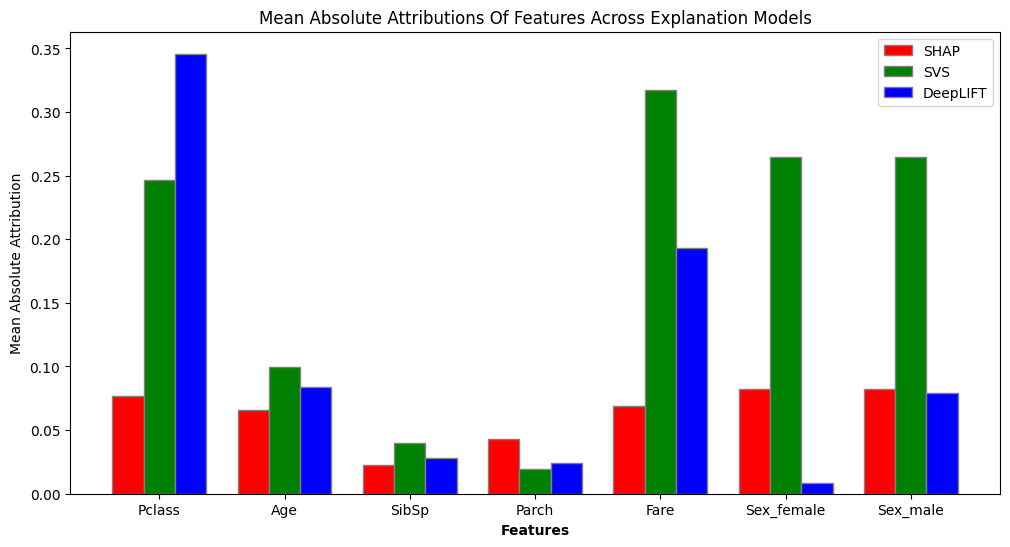

In [30]:
import matplotlib.pyplot as plt

# Take absolute values of the average attributions
average_shap_attributions_abs = np.abs(average_shap_attributions)
average_svs_attributions_abs = np.abs(average_svs_attributions)
average_deep_lift_attributions_abs = np.abs(average_deep_lift_attributions)

# Define positions of the bars on the x-axis
barWidth = 0.25
r1 = np.arange(len(average_shap_attributions_abs))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create the bar plot
plt.figure(figsize=(12, 6))

plt.bar(r1, average_shap_attributions_abs, color='r', width=barWidth, edgecolor='grey', label='SHAP')
plt.bar(r2, average_svs_attributions_abs, color='g', width=barWidth, edgecolor='grey', label='SVS')
plt.bar(r3, average_deep_lift_attributions_abs, color='b', width=barWidth, edgecolor='grey', label='DeepLIFT')

# Add xticks on the middle of the group bars
plt.xlabel('Features', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(average_shap_attributions_abs))], feature_names)

# Create legend & Show graphic
plt.ylabel('Mean Absolute Attribution')
plt.title('Mean Absolute Attributions Of Features Across Explanation Models')
plt.legend()
plt.show()


**(i)** 'Sex\_female', 'Sex\_male' and 'PClass' are the most important features for SVS, which reflects the historical context of women and first-class passengers having a higher survival rate.'Fare' is the highest attribute for DeepLIFT. Since this attribute has a high correlation with PClass, it supports the hypothesis that socio-economic status played a large role in survival chances. 'Age' appears to be of moderate importance across all methods. 'SibSp' and 'Parch' are less important, aligning with the hypothesis that family size did not determine survival outcomes.

**(ii)** The methods show differences in attributing importance to features, particularly with 'Sex\_female' and 'Sex\_male'. SHAP and SVS treat these as equivalent due to one-hot encoding, making them mutually exclusive. This causes both features to receive similar importance scores since changes to one reflect inversely on the other, affecting prediction outcomes equally. DeepLIFT, however, places more importance on 'Sex\_male', suggesting potential discrepancies or learned interaction effects that differently influence predictions based on these features' presence. This difference might stem from training data patterns or model-learned biases.

DeepLIFT also assigns greater importance to 'Fare' compared to SHAP and SVS, likely due to its sensitivity to feature interactions within the network. 'Fare' might be highlighted by DeepLIFT because of its interaction with other features, in a way that significantly affects the activation of neurons (especially PClass), and its potential as a proxy for socio-economic status.

Differences among the methods could stem from various factors. SHAP, grounded in game theory, aims for even attribution distribution across features, showing their cooperative impact. This uniformity across features in SHAP contrasts with the variability seen in SVS and DeepLIFT. SVS, relying on a sampling approach to estimate SHAP values, may exhibit attribution instability due to sampling randomness. In comparison, SHAP's determinism offers consistent attributions. DeepLIFT, which measures differences in neuron activation against a reference, can uncover feature interactions and non-linear relationships not as evident in other methods. This capacity might explain its more unique insights.

**(iii)** Attribution scores VS expectations:
The attribution scores generally match earlier expectations, however 'Pclass' was deemed to be more important than 'Fare' and 'Age' was not expected to be as important 'PClass' (refer to DeepLIFT in fig). Discrepancies in exact attribute scores may arise from neural networks capturing non-linear relationships not apparent in preliminary data analysis, unlike regression's linear focus. Features like 'Sex' and 'Pclass' might be emphasized more by models due to dataset imbalances, affecting their perceived importance.

**(ib)** Potential advantages and disadvantages:
SHAP values, consistent with exploratory data analysis (EDA), provide reliable attributions by accounting for feature interactions and being model-agnostic. However, its computational demands may hinder its use with larger or complex models, and it may not capture all non-linear relationships learned by neural networks. SVS offering a quicker approximation of feature importance, is useful for rapid insights into feature contributions. Yet, its sampling method introduces variability and may not fully reveal feature interactions as comprehensively as SHAP.
DeepLIFT's sensitivity to the contributions of features reveals complex interactions within the model, which explains why 'Fare' is given higher importance despite its less direct connection to survival outcomes.
However, the attributions can be significantly influenced by the choice of reference point, making it less stable.


**Task 2(c)**: Perform a quantitative evaluation of the different attribution methods by computing their mean [infidelity](https://captum.ai/api/metrics.html) on the full Titanic dataset. On a high level, infidelity aims to estimate how closely the generated explanations correspond with the behaviour of the explained model by slightly perturbing the inputs and measuring how much the observed change in the model output differs from the change predicted by the corresponding feature attributions (when considering a linear model with the same weights as the feature attribution scores). If you are interested, you can find more details regarding this metric in [the original paper](https://arxiv.org/abs/1901.09392). A downside of the infidelity metric is that one needs to define a suitable perturbation function for changing the model inputs, which can significantly affect the results. In this coursework, we provide you with a perturbation function adding Gaussian noise to continuous features and performing resampling for categorical features. In your evaluation, you should experiment with two or three different standard deviations and categorical resampling probabilities. Once you are done, add a table summarising the results to your report and comment on the findings. Note that lower infidelity scores are better.

Note: You should use `normalize=True` and `n_perturb_samples=10` as parameters to the Captum's infidelity function and set the same Torch and NumPy seeds before computing the infidelity for each method (so that all methods are evaluated using the same sample perturbations).

In [ ]:
from captum.metrics import infidelity, infidelity_perturb_func_decorator

def perturb_func_constructor(noise_scale, cat_resample_proba, background_dataset, feature_ids, n_perturb_samples=10):
    """
    You can call this function to construct a perturbation function with the desired parameters,
    which can then be provided as the perturb_func parameter to the infidelity metric implementation
    from Captum.

     Parameters:
        noise_scale (float): A standard deviation of the Gaussian noise added to the continuous features.
        cat_resample_proba (float): Probability of resampling a categorical feature.
        background_dataset (Tensor): A tensor of background data samples with the shape (num_samples, num_features).
        feature_ids (list): A list with feature IDs, same as in generate_coalitions.
        n_perturb_samples (int): The number of perturbed samples for each input. Should match the value
            of the corresponding parameter to the Captum's infidelity function.

    Returns:
        perturb_func (function): A perturbation function compatible with Captum
    """
    @infidelity_perturb_func_decorator(True)
    def perturb_func(inputs):
        # Construct masks for noise and resampling categorical variables
        noise_mask = torch.ones(1, inputs.size(1)).to(DEVICE)
        # We assume that categorical features are one-hot-encoded
        i = 0
        current_span_start = 0
        categorical_spans = []
        while i < len(feature_ids) - 1:
            if feature_ids[i] != feature_ids[i + 1] and current_span_start != i:
                categorical_spans.append((current_span_start, i))
                current_span_start = i + 1
            elif feature_ids[i] != feature_ids[i + 1]:
                current_span_start = i + 1
            elif feature_ids[i] == feature_ids[i + 1] and i == len(feature_ids) - 2:
                categorical_spans.append((current_span_start, i + 1))
            i += 1

        cat_resample_masks = []
        for i, (s, e) in enumerate(categorical_spans):
            cat_resample_mask = torch.zeros(inputs.shape).to(DEVICE)
            probabilities = torch.full((inputs.size(0), 1), cat_resample_proba)
            resample_tensor = torch.bernoulli(probabilities)
            noise_mask[:, s:e] = 0.
            cat_resample_mask[:, s:e] = resample_tensor
            cat_resample_masks.append(cat_resample_mask)

        # Add noise to continuous features only
        noise = torch.tensor(np.random.normal(0, noise_scale, inputs.shape)).float().to(DEVICE) * noise_mask
        perturbed_inputs = inputs - noise

        # Randomly resample categorical variables
        if categorical_spans:
            expanded_background_dataset = background_dataset.repeat((n_perturb_samples, 1))
            for cat_resample_mask in cat_resample_masks:
                random_perm = torch.randperm(expanded_background_dataset.size(0))
                random_samples = expanded_background_dataset[random_perm[:inputs.size(0)]]
                perturbed_inputs = perturbed_inputs * (1 - cat_resample_mask) + random_samples * cat_resample_mask

        return perturbed_inputs

    return perturb_func

In [ ]:
from captum.attr import DeepLift, ShapleyValueSampling
from captum.metrics import infidelity

# Assuming DEVICE is defined
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate attributions for the first 10 samples
infidelity_inputs = test_dataset.samples[:10].to(DEVICE)

# Compute attributions
shap_attributions_full_dataset = shap_attribute(titanicmodel, infidelity_inputs, test_dataset.samples, feature_mask[0].tolist())
svs = ShapleyValueSampling(titanicmodel.to(DEVICE))
deeplift = DeepLift(titanicmodel.to(DEVICE))

svs_estim_atts_fulldata = svs.attribute(infidelity_inputs, target=0)
deeplift_atts_fulldata = deeplift.attribute(infidelity_inputs)

# Parameters for perturbation
noises = [0.1, 0.5, 1]
resampling_probs = [0.1, 0.3, 0.5]

for noise_scale, cat_resample_proba in zip(noises, resampling_probs):
    perturb_func = perturb_func_constructor(noise_scale=noise_scale, cat_resample_proba=cat_resample_proba, background_dataset=test_dataset.samples, feature_ids=[0,1,2,3,4,5,6], n_perturb_samples=10)

    # Compute Infidelity scores for SHAP, SVS, and DeepLIFT
    # SHAP
    shap_data_infi = infidelity(
        forward_func=titanicmodel,
        perturb_func=perturb_func,
        inputs=infidelity_inputs,
        attributions=shap_attributions_full_dataset,
        n_perturb_samples=10,
        normalize=True
    ).mean()

    # SVS
    svs_data_infi = infidelity(
        forward_func=titanicmodel,
        perturb_func=perturb_func,
        inputs=infidelity_inputs,
        attributions=svs_estim_atts_fulldata,
        n_perturb_samples=10,
        normalize=True
    ).mean()

    # DeepLIFT
    dl_data_infi = infidelity(
        forward_func=titanicmodel,
        perturb_func=perturb_func,
        inputs=infidelity_inputs,
        attributions=deeplift_atts_fulldata,
        n_perturb_samples=10,
        normalize=True
    ).mean()

    print(f'noise_scale = {noise_scale} and cat_resample_proba = {cat_resample_proba}')
    print(f'SHAP Mean Infidelity: {shap_data_infi.item()}')
    print(f'SVS Mean Infidelity: {svs_data_infi.item()}')
    print(f'DeepLIFT Mean Infidelity: {dl_data_infi.item()}')

noise_scale = 0.1 and cat_resample_proba = 0.1
SHAP Mean Infidelity: 0.04484087973833084
SVS Mean Infidelity: 0.031920384615659714
DeepLIFT Mean Infidelity: 0.03214432671666145
noise_scale = 0.5 and cat_resample_proba = 0.3
SHAP Mean Infidelity: 0.12938658893108368
SVS Mean Infidelity: 0.1301935911178589
DeepLIFT Mean Infidelity: 0.088067926466465
noise_scale = 1 and cat_resample_proba = 0.5
SHAP Mean Infidelity: 0.13297446072101593
SVS Mean Infidelity: 0.1893804371356964
DeepLIFT Mean Infidelity: 0.21553146839141846


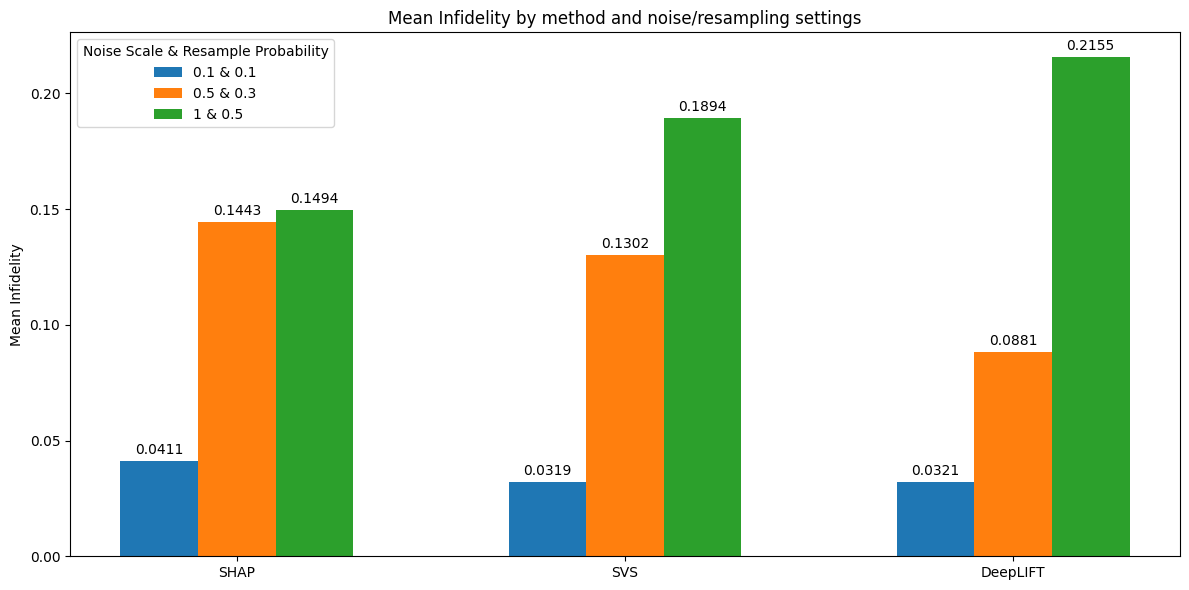

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
methods = ['SHAP', 'SVS', 'DeepLIFT']
infidelities = {
    '0.1 & 0.1': [0.041129838675260544, 0.031920384615659714, 0.03214432671666145],
    '0.5 & 0.3': [0.1442929357290268, 0.1301935911178589, 0.088067926466465],
    '1 & 0.5': [0.14940805733203888, 0.1893804371356964, 0.21553146839141846]
}

# Setup for grouped bar chart
x = np.arange(len(methods))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, infidelities['0.1 & 0.1'], width, label='0.1 & 0.1')
rects2 = ax.bar(x, infidelities['0.5 & 0.3'], width, label='0.5 & 0.3')
rects3 = ax.bar(x + width, infidelities['1 & 0.5'], width, label='1 & 0.5')

# Add labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Infidelity')
ax.set_title('Mean Infidelity by method and noise/resampling settings')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend(title='Noise Scale & Resample Probability')

# Function to attach a text label above each bar, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function to label the heights of bars
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()


**Task 2(d)**: Evaluate the computational efficiency of the different methods by taking the following steps: <br />
**(i)** Preproccess the [Dry Bean Dataset](https://archive.ics.uci.edu/dataset/602/dry+bean+dataset), similarly to what we have done for Titanic. You can find the description of the different features on the dataset webpage along with the instructions on how to import the data in a Python environment. You do not need to perform any exploratory data analysis for this dataset. <br />
**(ii)** Train an additional neural model on the preprocessed data. Briefly report the key performance metrics for the model in your report. <br />
**(iii)** Compute the runtimes required to produce the attribution scores for the different methods when considering the first 200 samples in the Titanic and Dry Bean test sets. Report the results in a table in your report. Which methods seem to be the most/least computationally efficient?

In [ ]:
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Fetch the dataset
dry_bean_dataset = fetch_ucirepo(id=602)

# Data (as pandas dataframes)
X = dry_bean_dataset.data.features
y = dry_bean_dataset.data.targets

# Metadata and variable information
print(dry_bean_dataset.metadata)
print(dry_bean_dataset.variables)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define the scaler
scaler = StandardScaler()

# Since all features are numerical, we'll scale all of them
numerical_features = X.columns.tolist()

# Create a ColumnTransformer to scale numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_features),
    ],
    remainder='passthrough'  # We don't have categorical features to encode in X
)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Apply the transformations
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Convert the scaled data and labels into PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float), torch.tensor(y_test, dtype=torch.long))

# Create DataLoaders
drybean_train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)
drybean_test_dl = DataLoader(test_dataset, batch_size=64, shuffle=False)


{'uci_id': 602, 'name': 'Dry Bean Dataset', 'repository_url': 'https://archive.ics.uci.edu/dataset/602/dry+bean+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/602/data.csv', 'abstract': 'Images of 13,611 grains of 7 different registered dry beans were taken with a high-resolution camera. A total of 16 features; 12 dimensions and 4 shape forms, were obtained from the grains.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 13611, 'num_features': 16, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C50S4B', 'creators': [], 'intro_paper': {'title': 'Multiclass classification of dry beans using computer vision and machine learning techniques', 'authors': 'M. Koklu, Ilker Ali Özkan', 'published_in': 'Computers and El

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
import os

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo


class DryBeanDataset(Dataset):
    """
    Loads and preprocesses the Dry Bean dataset.
    """

    # Unique key for proper initialisation
    __create_key = object()

    @classmethod
    def create_datasets(
        cls,
        split_seed=42,
        test_size=0.2,
    ):
        """
        Creates training and testing datasets with specified split parameters.

        Parameters:
            split_seed (int): Seed for reproducible splitting.
            test_size (float): Proportion of data to be used for testing.

        Returns:
            train_dataset_db (DryBeanDataset): Training dataset.
            test_dataset_db (DryBeanDataset): Testing dataset.
        """
        train_dataset_db = DryBeanDataset(
            cls.__create_key,
            split_seed=split_seed,
            test_size=test_size,
            train=True,
        )
        test_dataset_db = DryBeanDataset(
            cls.__create_key,
            split_seed=split_seed,
            test_size=test_size,
            train=False,
        )
        return train_dataset_db, test_dataset_db

    def __init__(
        self,
        create_key=None,
        split_seed=42,
        test_size=0.2,
        train=True,
    ):
        """
        Initialises DryBeanDataset with specified split parameters.

        Parameters:
            create_key (object): Unique key for proper initialisation.
            split_seed (int): Seed for reproducible splitting.
            test_size (float): Proportion of data to be used for testing.
            train (bool): Flag indicating whether to load training or testing data.
        """
        # Ensure that the dataset is being constructed properly
        if create_key != DryBeanDataset.__create_key:
            raise ValueError(
                "Illegal initialisation attempt — please use create_datasets to initialise."
            )

        # Load Dry Bean dataset from Excel file
        try:
            data_df = pd.read_excel("drive/MyDrive/Ethics/DryBeanDataset/Dry_Bean_Dataset.xlsx")
        except FileNotFoundError:
            raise FileNotFoundError("Dry bean data file not found.")

        # Fetch the Dry Bean dataset from UCIML repository
        dry_bean_dataset = fetch_ucirepo(id=602)

        # Preprocess the fetched dataset
        X = dry_bean_dataset.data.features
        X = X.drop(columns=['ConvexArea', 'EquivDiameter','ShapeFactor3'])
        db = preprocessing.LabelEncoder()
        db.fit(dry_bean_dataset.data.targets['Class'])
        y = dry_bean_dataset.data.targets
        y['Class'] = db.transform(y['Class'])
        x_train_db, x_test_db, y_train_db, y_test_db = train_test_split(
            X, y, test_size=test_size, random_state=split_seed, shuffle=True
        )
        if train:
            self.raw_data = x_train_db, y_train_db
        else:
            self.raw_data = x_test_db, y_test_db

        # Preprocess the data
        x_train_processed_db, preprocessor = preprocess_train_data(
            x_train_db, categorical_features=[]
        )
        x_train_db = pd.DataFrame(
            x_train_processed_db, columns=preprocessor.get_feature_names_out()
        )
        x_test_processed_db = preprocess_test_data(x_test_db, preprocessor)
        x_test_db = pd.DataFrame(
            x_test_processed_db, columns=preprocessor.get_feature_names_out()
        )

        # Select data partition and convert to tensors
        if train:
            samples = x_train_db
            labels = y_train_db
        else:
            samples = x_test_db
            labels = y_test_db
        self.samples = torch.tensor(samples.to_numpy(), dtype=torch.float32)
        self.labels = torch.tensor(labels.to_numpy(), dtype=torch.long)
        self.features = preprocessor.get_feature_names_out()
        self.preprocessor = preprocessor

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: Length of the dataset.
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Returns a sample and its corresponding label at the given index.

        Parameters:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the sample and its corresponding label.
        """
        return self.samples[idx], self.labels[idx]


In [ ]:
train_dataset_db, test_dataset_db = DryBeanDataset.create_datasets()

# Access the features attribute from either dataset
feature_names = train_dataset_db.features

feature_ids_db = list(range(len(feature_names)))

print("Feature Names:", feature_names)
print("Feature IDs:", feature_ids_db)


/tmp/ipykernel_2978/870617178.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Class'] = db.transform(y['Class'])


Feature Names: ['num__Area' 'num__Perimeter' 'num__MajorAxisLength'
 'num__MinorAxisLength' 'num__AspectRatio' 'num__Eccentricity'
 'num__Extent' 'num__Solidity' 'num__Roundness' 'num__Compactness'
 'num__ShapeFactor1' 'num__ShapeFactor2' 'num__ShapeFactor4']
Feature IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


/tmp/ipykernel_2978/870617178.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Class'] = db.transform(y['Class'])


In [ ]:
from google.colab import drive
drive.mount('drive/')

Drive already mounted at drive/; to attempt to forcibly remount, call drive.mount("drive/", force_remount=True).


In [ ]:
train_dataset_db, test_dataset_db = DryBeanDataset.create_datasets(
    test_size=0.2,
    split_seed=42,
)

# DataLoader instances for DryBean
train_dl_db = DataLoader(train_dataset_db, batch_size=32, shuffle=True)
test_dl_db = DataLoader(test_dataset_db, batch_size=32, shuffle=False)

/tmp/ipykernel_2978/870617178.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Class'] = db.transform(y['Class'])
/tmp/ipykernel_2978/870617178.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Class'] = db.transform(y['Class'])


In [ ]:
from sklearn.metrics import f1_score
import torch
from torch.utils.data import DataLoader
from torch import nn

def construct_nn(nn_dims, activation_fun):
    """
    Constructs a neural network with a specified architecture for multi-class classification.
    """
    layers = []
    # Construct hidden layers with the specified activation function
    for i in range(1, len(nn_dims) - 1):
        in_dim, out_dim = nn_dims[i-1], nn_dims[i]
        layers.append(nn.Linear(in_dim, out_dim))
        layers.append(activation_fun())
    # Add the output layer without an activation function; for use with CrossEntropyLoss
    layers.append(nn.Linear(nn_dims[-2], nn_dims[-1]))

    # Assemble the layers into a sequential model
    return nn.Sequential(*layers)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_nn(model, train_dl, num_epochs=100, device=DEVICE):
    """
    Trains a neural network model using the specified training data loader.
    """
    model.to(device)
    # Define the loss function and the optimiser
    loss_fun = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=0.005)
    model.train()

    # Iterate over epochs for training
    for epoch in range(num_epochs):
        total_loss = 0
        # Iterate over the batched dataset
        for x, y in train_dl:
            # Transfer batch data to the computation device
            x, y = x.to(device), y.to(device).squeeze()
            # Zero the gradients before backward pass
            opt.zero_grad()
            # Forward pass to get the model's predictions
            out = model(x)
            # Compute the loss
            loss = loss_fun(out, y)
            total_loss += loss.item()
            # Backward pass to compute gradients
            loss.backward()
            # Update model parameters
            opt.step()

        # Print the average loss for the epoch
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_dl)}")

In [ ]:
current_dir = '/content/drive/MyDrive/Ethics/'# Define the path to save the model

nn_dims_db = [train_dataset_db.samples.shape[1], 256, 256, 7]

# Construct the model for multi-class classification
drybeanmodel = construct_nn(nn_dims_db, nn.ReLU).to(DEVICE)

# Load the model's state dictionary
model_load_path = current_dir + 'DryBeanDataset/' + 'drybean_model.pt'
drybeanmodel.load_state_dict(torch.load(model_load_path, map_location=DEVICE))

# Move the model to the appropriate device
model_to_load = drybeanmodel.to(DEVICE)

In [ ]:
import torch
import torch.nn as nn
from sklearn import preprocessing

# Load datasets
train_dataset_db, test_dataset_db = DryBeanDataset.create_datasets()

# DataLoader instances for DryBean
train_dl_db = DataLoader(train_dataset_db, batch_size=32, shuffle=True)
test_dl_db = DataLoader(test_dataset_db, batch_size=32, shuffle=False)

nn_dims_db = [13, 256, 256, 7]

# Construct the model
drybean_model = construct_nn(nn_dims_db, nn.ReLU).to(DEVICE)

# Train the model
print("———————[ Model training for DryBean Dataset ]———————")
train_nn(drybean_model, train_dl_db, num_epochs=1000)
print("Training completed!")

# Save the model for DryBean
current_dir_db = '/content/drive/MyDrive/Ethics/DryBeanDataset/'
model_save_path_db = current_dir_db + 'drybean_model.pt'
torch.save(drybean_model.state_dict(), model_save_path_db)
print(f"Model saved to {model_save_path_db}")


/tmp/ipykernel_2978/870617178.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Class'] = db.transform(y['Class'])
/tmp/ipykernel_2978/870617178.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Class'] = db.transform(y['Class'])


———————[ Model training for DryBean Dataset ]———————
Epoch 1, Loss: 0.29747456789584803
Epoch 2, Loss: 0.23462421810281767
Epoch 3, Loss: 0.21100709499119402
Epoch 4, Loss: 0.20523936814926236
Epoch 5, Loss: 0.20556514699263306
Epoch 6, Loss: 0.19993047551675278
Epoch 7, Loss: 0.20122065498149486
Epoch 8, Loss: 0.19617079154662023
Epoch 9, Loss: 0.19162543961242978
Epoch 10, Loss: 0.19080626181821145
Epoch 11, Loss: 0.18700296478209433
Epoch 12, Loss: 0.18676754531294895
Epoch 13, Loss: 0.18087977365948413
Epoch 14, Loss: 0.1796621558395736
Epoch 15, Loss: 0.1783769178665803
Epoch 16, Loss: 0.17870140654687658
Epoch 17, Loss: 0.18222021996494261
Epoch 18, Loss: 0.17688450278424797
Epoch 19, Loss: 0.1717481642273252
Epoch 20, Loss: 0.17255422950905264
Epoch 21, Loss: 0.1686586090923448
Epoch 22, Loss: 0.16754397238083074
Epoch 23, Loss: 0.1709335886892423
Epoch 24, Loss: 0.16526224965344338
Epoch 25, Loss: 0.16975591068983603
Epoch 26, Loss: 0.16682005095189092
Epoch 27, Loss: 0.1611200

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from torch.nn.functional import softmax

def eval_nn(model, test_dataset):
    # Set the model to evaluation mode
    model.eval()
    device = next(model.parameters()).device

    # Initialise the cross-entropy loss function
    loss_fun = nn.CrossEntropyLoss()
    # Create a data loader for the test dataset
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialise total loss and lists to store all labels and outputs
    total_loss = 0
    all_labels = []
    all_outputs = []

    # Iterate through the test data loader
    for inputs, labels in test_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device).squeeze()

        # Perform a forward pass and calculate loss without computing gradients
        with torch.no_grad():
            outputs = model(inputs)
            loss = loss_fun(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            # Collect labels and raw outputs for later metric computation
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    # Calculate the average loss over all test batches
    avg_loss = total_loss / len(test_loader)
    # Convert label and output lists to Numpy arrays
    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)

    # Convert raw outputs to probabilities using softmax
    all_outputs_softmax = softmax(torch.tensor(all_outputs), dim=1).numpy()
    # Predict the class with the highest probability for each output
    all_predictions = all_outputs_softmax.argmax(axis=1)

    # Calculate the accuracy across all test samples
    accuracy = accuracy_score(all_labels, all_predictions)

    # Calculate the weighted F1 score across all test samples
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # Calculate the AUC score for each class using one-hot encoded labels and predicted probabilities
    num_classes = len(np.unique(all_labels))
    all_labels_one_hot = label_binarize(all_labels, classes=range(num_classes))
    auc_score = roc_auc_score(all_labels_one_hot, all_outputs_softmax, multi_class='ovr', average='weighted')

    return avg_loss, accuracy, f1, auc_score

# Evaluate the model and print out the metrics
avg_loss, accuracy, f1, auc = eval_nn(drybeanmodel, test_dataset_db)
print(f"Average loss: {avg_loss}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"AUC Score: {auc}")


Average loss: 0.35243542544370476
Accuracy: 0.9210429673154609
F1 Score: 0.9211695145240139
AUC Score: 0.9900187532328856


In [ ]:
import os

class TitanicDataset(Dataset):
    """
    Loads and preprocesses the Titanic dataset.
    """
    __create_key = object()

    @classmethod
    def create_datasets(
        cls,
        label_name="survived",
        split_seed=42,
        test_size=0.2,
    ):
        train_dataset = TitanicDataset(
            cls.__create_key,
            label_name=label_name,
            split_seed=split_seed,
            test_size=test_size,
            train=True,
        )
        test_dataset = TitanicDataset(
            cls.__create_key,
            label_name=label_name,
            split_seed=split_seed,
            test_size=test_size,
            train=False,
        )
        return train_dataset, test_dataset

    def __init__(
        self,
        create_key=None,
        label_name="Survived",
        split_seed=42,
        test_size=0.2,
        train=True,
    ):
        # Ensure that the dataset is being constructed properly
        if create_key != TitanicDataset.__create_key:
            raise ValueError(
                "Illegal initialisation attempt — please use create_datasets to initialise."
            )

        try:
            data_df = pd.read_csv("drive/MyDrive/Ethics/titanic-dataset.csv")
        except FileNotFoundError:
            raise FileNotFoundError("Titanic data file not found.")

        # Split the dataset into train and test
        x = data_df.drop(columns=[label_name, "name", "ticket", "cabin", "embarked", "boat", "body", "home.dest"])
        # For the purposes of this coursework, we just impute the missing age and fare with a median value
        x[['age']] = x[['age']].fillna(x[['age']].median())
        x[['fare']] = x[['fare']].fillna(x[['fare']].median())
        y = data_df[label_name]
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=test_size, random_state=split_seed, shuffle=True
        )
        if train:
            self.raw_data = x_train, y_train
        else:
            self.raw_data = x_test, y_test

        # Preprocess the data
        x_train_processed, preprocessor = preprocess_train_data(
            x_train, categorical_features=["sex"]
        )
        x_train = pd.DataFrame(
            x_train_processed, columns=preprocessor.get_feature_names_out()
        )
        x_test_processed = preprocess_test_data(x_test, preprocessor)
        x_test = pd.DataFrame(
            x_test_processed, columns=preprocessor.get_feature_names_out()
        )

        # Select data partition and convert to tensors
        if train:
            samples = x_train
            labels = y_train
        else:
            samples = x_test
            labels = y_test
        self.samples = torch.tensor(samples.to_numpy(), dtype=torch.float32)
        self.labels = torch.tensor(labels.to_numpy(), dtype=torch.long)
        self.features = preprocessor.get_feature_names_out()
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]


train_dataset, test_dataset = TitanicDataset.create_datasets(
    test_size=0.2,
    split_seed=42,
)


In [ ]:
from captum.attr import DeepLift, ShapleyValueSampling
import time
from tqdm import tqdm

# Function to measure the runtime of an attribution method
def measure_runtime(method, samples, model, feature_ids=None, background_samples=None, DEVICE=torch.device("cpu")):
    # Record the start time
    start_time = time.time()
    # If SHAP method is used, compute SHAP attributions
    if method == 'shap_attribute':
        attributions = [shap_attribute(model, sample.unsqueeze(0).to(DEVICE), background_samples, feature_ids) for sample in samples]
    else:
        # For other methods, compute attributions directly
        attributions = [method.attribute(sample.unsqueeze(0).to(DEVICE), target=0) for sample in samples]
    # Record the end time
    end_time = time.time()
    # Return the elapsed time
    return end_time - start_time

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
titanicmodel = titanicmodel.to(DEVICE)
drybeanmodel = drybeanmodel.to(DEVICE)

# Initialise the methods
svs = ShapleyValueSampling(titanicmodel.to(DEVICE))
deep_lift = DeepLift(titanicmodel.to(DEVICE))

# Compute attributions
svs_attributions = [svs.attribute(sample.unsqueeze(0).to(DEVICE), target=0, feature_mask=torch.tensor([feature_ids]).to(DEVICE)) for sample in random_samples]
deep_lift_attributions = [deep_lift.attribute(sample.unsqueeze(0).to(DEVICE), target=0) for sample in random_samples]

# Initialise DeepLift and SVS for both Titanic and Dry Bean models
deep_lift_titanic = DeepLift(titanicmodel)
shapley_value_sampling_titanic = ShapleyValueSampling(titanicmodel)
deep_lift_drybean = DeepLift(drybeanmodel)
shapley_value_sampling_drybean = ShapleyValueSampling(drybeanmodel)

titanic_samples = test_dataset.samples[:200].to(DEVICE)
drybean_samples = test_dataset_db.samples[:200].to(DEVICE)

# Background samples are used for computing SHAP values
background_samples_titanic = train_dataset.samples[background_indices]
background_samples_drybean = train_dataset_db.samples[background_indices]  #

# Compute and print runtimes for Titanic dataset
runtime_deep_lift_titanic = measure_runtime(deep_lift_titanic, titanic_samples, titanicmodel, DEVICE=DEVICE)
runtime_svs_titanic = measure_runtime(shapley_value_sampling_titanic, titanic_samples, titanicmodel, DEVICE=DEVICE)
runtime_shap_titanic = measure_runtime('shap_attribute', titanic_samples, titanicmodel, feature_ids=feature_ids, background_samples=background_samples_titanic, DEVICE=DEVICE)

print(f"DeepLIFT Runtime Titanic: {runtime_deep_lift_titanic}s")
print(f"SVS Runtime Titanic: {runtime_svs_titanic}s")
print(f"SHAP Runtime Titanic: {runtime_shap_titanic}s")

# Compute and print runtimes for Dry Bean dataset
runtime_deep_lift_drybean = measure_runtime(deep_lift_drybean, drybean_samples, drybeanmodel, DEVICE=DEVICE)
runtime_svs_drybean = measure_runtime(shapley_value_sampling_drybean, drybean_samples, drybeanmodel, DEVICE=DEVICE)
runtime_shap_drybean = measure_runtime('shap_attribute', drybean_samples, drybean_model, feature_ids=feature_ids_db, background_samples=background_samples_drybean, DEVICE=DEVICE)

print(f"DeepLIFT Runtime Dry Bean: {runtime_deep_lift_drybean}s")
print(f"SVS Runtime Dry Bean: {runtime_svs_drybean}s")
print(f"SHAP Runtime Dry Bean: {runtime_shap_drybean}s")

## Counterfactual Explanations

### Designing a Distance Metric

**Task 3(a)**: First, we need to specify a suitable distance metric for measuring the closeness between the points. Depending on the dataset, one could choose the standard distance functions like the Manhattan (L1) distance, Euclidean (L2) distance, and more specialised ones like Gower distance for better handling datasets with both categorical and continuous dataset. However, the design of distance metric can be very flexible. For example, the standard L1 distance is (k is the number of features) $$d_{L1}(x, x') = \sum_{i}^{k} |x_i-x'_i|$$

If the features have different value ranges, we could normalise the L1 distance with the maximum and minimum values of each feature (indexed $i$) in the training dataset, $max_i$, $min_i$ : $$d_{L1, normalised}(x, x') = \sum_{i}^{k} |(x_i-x'_i)/(max_i-min_i)|$$

On top of this, we could also add customised weighting factors $\mathbf{w}=w_1, ..., w_k$ to capture the importance of each feature, and the weighted L1 distance is: $$d_{L1, normalised, weighted}(x, x') = \sum_{i}^{k} w_i|(x_i-x'_i)/(max_i-min_i)|$$

Given the background above, we want to design a distance function for the preprocessed version of our Titanic dataset. Explore the dataset characteristics and answer the following questions:
**a)** Briefly discuss the weighting of each input variable in the preprocessed dataset, if we use standard L1 and normalised L1?
**b)** If we want to treat each feature equally in the original unprocessed dataset, how would you design the distance metric for the preprocessed dataset using L1-based distance? Write down the detail of your distance function for the preprocessed dataset and justify why each original feature is treated equally.
**c)** Implement your distance function below

**(a)** The standard L1 distance measures the absolute differences between the coordinates of two objects, crucial for counterfactual explanations that identify the minimal changes needed to modify a model's prediction. However, its effectiveness is compromised when features vary in scale, as it tends to overemphasize features with larger scales. To address this issue, normalized L1 distance is proposed, dividing each feature's difference by its range. This normalization makes the contribution of each feature to the distance metric more equitable, enabling a more balanced comparison of feature changes.
Normalization is vital for generating meaningful counterfactuals, as it prevents the metric from being skewed by features with large numerical ranges. This ensures that counterfactual modifications are realistic and significant in real-world terms. Theoretically, using normalized distances in counterfactual explanations adheres to Pareto efficiency, seeking explanations that are both minimally and globally optimal, taking into account the actual scale of the data features.


**(b)** Distance function: For an L1-based distance metric applied to a preprocessed dataset, adjusting for different feature scales is essential to ensure fairness. Equal weighting prevents features with larger ranges, like 'fare', from overpowering smaller or binary features, such as 'pclass' or 'sex' encodings. Since preprocessing like normalization changes feature scales, using a simple L1 distance could be biased.  Our distance function normalizes feature differences by their range, allowing every feature to equally influence the distance. To ensure that each original feature is treated equally, the weights should be set to 1, and the normalization step should adjust for the different scales of the features resulting from preprocessing.

In [ ]:
# calculate the min and max values from the training set
all_features, _ = train_dataset[:]
global_min_values = all_features.min(dim=0)[0]  # Minimum values for each feature across the dataset
global_max_values = all_features.max(dim=0)[0]  # Maximum values for each feature across the dataset

# define the distance function using these global variables
def distance_function(x1, x2):
    """
    Weighted and normalized L1 distance function.

    Parameters:
        x1 (Tensor): A 1-d tensor of shape (k,) representing the first sample.
        x2 (Tensor): A 1-d tensor of shape (k,) representing the second sample.

    Returns:
        distance (float): The normalized, weighted L1 distance between x1 and x2.
    """
    # Use the global min and max values within the function
    global global_min_values, global_max_values

    no_of_features = len(x1)
    weights = torch.tensor([1] * no_of_features)  # Example weights
    normalised_diff = torch.abs(x1 - x2) / (global_max_values - global_min_values)
    distance = torch.sum(weights * normalised_diff)
    return distance

### Nearest-Neighbour Counterfactual Explanations (NNCE)

**Task 3(b)**: As introduced in the tutorial, NNCEs are a simple yet effective method for finding counterfactuals. Implement the NNCE functions.

Instructions:
1. determine desired label for the counterfactual
2. find the dataset points with desired label as predicted by the model
3. find the point with the minimum distance and return it as NNCE

In [ ]:
class TitanicDataset(Dataset):
    """
    Loads and preprocesses the Titanic dataset.
    """
    __create_key = object()

    @classmethod
    def create_datasets(
        cls,
        label_name="survived",
        split_seed=42,
        test_size=0.2,
    ):
        train_dataset = TitanicDataset(
            cls.__create_key,
            label_name=label_name,
            split_seed=split_seed,
            test_size=test_size,
            train=True,
        )
        test_dataset = TitanicDataset(
            cls.__create_key,
            label_name=label_name,
            split_seed=split_seed,
            test_size=test_size,
            train=False,
        )
        return train_dataset, test_dataset

    def __init__(
        self,
        create_key=None,
        label_name="Survived",
        split_seed=42,
        test_size=0.2,
        train=True,
    ):
        # Ensure that the dataset is being constructed properly
        if create_key != TitanicDataset.__create_key:
            raise ValueError(
                "Illegal initialisation attempt — please use create_datasets to initialise."
            )

        try:
            data_df = pd.read_csv("drive/MyDrive/Ethics/titanic-dataset.csv")
        except FileNotFoundError:
            raise FileNotFoundError("Titanic data file not found.")

        # Split the dataset into train and test
        x = data_df.drop(columns=[label_name, "name", "ticket", "cabin", "embarked", "boat", "body", "home.dest"])
        # For the purposes of this coursework, we just impute the missing age and fare with a median value
        x[['age']] = x[['age']].fillna(x[['age']].median())
        x[['fare']] = x[['fare']].fillna(x[['fare']].median())
        y = data_df[label_name]
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=test_size, random_state=split_seed, shuffle=True
        )
        if train:
            self.raw_data = x_train, y_train
        else:
            self.raw_data = x_test, y_test

        # Preprocess the data
        x_train_processed, preprocessor = preprocess_train_data(
            x_train, categorical_features=["sex"]
        )
        x_train = pd.DataFrame(
            x_train_processed, columns=preprocessor.get_feature_names_out()
        )
        x_test_processed = preprocess_test_data(x_test, preprocessor)
        x_test = pd.DataFrame(
            x_test_processed, columns=preprocessor.get_feature_names_out()
        )

        # Select data partition and convert to tensors
        if train:
            samples = x_train
            labels = y_train
        else:
            samples = x_test
            labels = y_test
        self.samples = torch.tensor(samples.to_numpy(), dtype=torch.float32)
        self.labels = torch.tensor(labels.to_numpy(), dtype=torch.long)
        self.features = preprocessor.get_feature_names_out()
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]


train_dataset, test_dataset = TitanicDataset.create_datasets(
    test_size=0.2,
    split_seed=42,
)


In [ ]:
all_features, _ = train_dataset[:]
max_values = all_features.max(dim=0)[0]  # Maximum values for each feature across the dataset
min_values = all_features.min(dim=0)[0]  # Minimum values for each feature across the dataset

weights = torch.ones(all_features.shape[1])


def compute_nnce(x, m, train_set, dist):
    """
    Function to compute NNCE with the adapted distance function.

    Parameters:
        x (Tensor): Input, a 1-d array of shape (k,)
        m (Sequential): Our neural network
        train_set (Dataset): Our dataset, could be TitanicDataset or DryBeanDataset
        dist (function): The distance function to use for calculating distances

    Returns:
        nnce (Tensor): Nearest neighbour counterfactual explanation, a 1-d array of shape (k,)
    """
    # Ensure the model is in evaluation mode
    m.eval()

    # Determine the desired label for the counterfactual
    desired_label = 1 - torch.round(m(x.unsqueeze(0))).item()

    # Initialise variables for minimum distance and the NNCE
    min_distance = float('inf')
    nnce = None

    # Iterate over the dataset
    for i in range(len(train_set)):
        data_point, target = train_set[i]
        data_point = data_point.unsqueeze(0).to(DEVICE)
        predicted_label = torch.round(m(data_point)).item()
        if predicted_label == desired_label:
            # Calculate the distance from the current point to the input x using the provided distance function
            current_distance = dist(x, data_point.squeeze(0))

            # Update the NNCE if the current point is closer
            if current_distance < min_distance:
                min_distance = current_distance
                nnce = data_point.squeeze(0)

    return nnce


In [ ]:
# use this code block to test if your function is working
# first print out the original input's prediction result
test_input = test_dataset.samples.to(DEVICE)[0]
print(titanicmodel(test_input))

# now compute NNCE and print out the NNCE's prediction result. Ideally this is different from the result for the original input.
nnce = compute_nnce(test_input, titanicmodel, train_set=train_dataset, dist=distance_function)
print(titanicmodel(nnce))

tensor([0.0023], grad_fn=<SigmoidBackward0>)
tensor([0.5233], grad_fn=<SigmoidBackward0>)


### Gradient-Based Counterfactual Explanations

**Task 3(c)**: Complete the PyTorch implementation for the gradient-based method in [Wachter et al. 2017]: WAC.

Instructions:
1. We are going to optimise the following loss function to find a counterfactual x': $  argmin_{x'} \text{ } BCE(y', (1-y)) + \lambda cost(x, x')$, where $BCE$ is binary cross entropy loss, $y'$ is the predicted label of $x'$, $y$ is the predicted label of $x$, $cost(,)$ is your chosen distance function in Task 1, and $\lambda$ is the trade-off parameter between validity and proximity. First, implement your chosen distance metric in ```CostLoss.forward()```
2. Follow the code structure in the ```compute_wac()``` function, complete the implementation.
    2.1. specify the target label for the counterfactual
    2.2. implement gradient descent procedures

In [ ]:
import torch
import torch.nn as nn

class CostLoss(nn.Module):
    def __init__(self, max_values, min_values, weights):
        """
        Initialises the CostLoss module with normalization parameters and weights for each feature.

        Parameters:
            max_values (Tensor): A tensor of shape (k,) with max values for each feature.
            min_values (Tensor): A tensor of shape (k,) with min values for each feature.
            weights (Tensor): A tensor of shape (k,) with weights for each feature.
        """
        super(CostLoss, self).__init__()
        self.max_values = max_values
        self.min_values = min_values
        self.weights = weights

    def forward(self, x1, x2):
        """
        Calculates the normalised, weighted L1 distance between x1 and x2 as the cost.

        Parameters:
            x1 (Tensor): A 1-d tensor of shape (k,) representing a data point.
            x2 (Tensor): A 1-d tensor of shape (k,) representing another data point.

        Returns:
            distance (Tensor): A real number representing the cost.
        """
        # Normalise the inputs
        normalized_x1 = (x1 - self.min_values) / (self.max_values - self.min_values)
        normalized_x2 = (x2 - self.min_values) / (self.max_values - self.min_values)

        # Calculate the weighted L1 distance
        dist = torch.sum(self.weights * torch.abs(normalized_x1 - normalized_x2))

        return dist


In [ ]:
from torch.autograd import Variable
from torch.optim import Adam
import datetime

def compute_wac(x, m, cost_loss_instance, lamb=0.1, lr=0.01, max_iter=1000, max_allowed_minutes=0.5):
    """
    Identifies a counterfactual point using the Weighted Average Causality approach.

    Parameters:
        x: The original input tensor for which we are seeking a counterfactual.
        m: The predictive model for which the counterfactual is sought.
        cost_loss_instance: Instance of a class that computes the cost associated with the counterfactual.
        lamb: Regularisation parameter that balances the loss terms.
        lr: Learning rate for the optimisation algorithm.
        max_iter: The maximum number of iterations for the optimisation.
        max_allowed_minutes: The maximum allowed time for the optimisation in minutes.

    Returns:
        A tensor representing the counterfactual instance.
    """
    x = x.to(DEVICE)
    # Initialises the counterfactual as a tensor with gradient tracking
    wac = Variable(x.clone(), requires_grad=True).to(DEVICE)
    optimiser = Adam([wac], lr, amsgrad=True)

    # Loss function to measure the validity of the counterfactual
    validity_loss = torch.nn.BCEWithLogitsLoss()

    # Original prediction to determine the target class for the counterfactual
    original_pred = torch.sigmoid(m(x.unsqueeze(0))).item()
    y_target = torch.tensor([0 if original_pred >= 0.5 else 1], dtype=torch.float).to(DEVICE)

    # Records the start time for enforcing the time limit
    start_time = datetime.datetime.now()
    # Defines the time limit for the optimisation process
    time_limit = datetime.timedelta(minutes=max_allowed_minutes)

    # Iterative optimisation process to find the counterfactual
    for iteration in range(max_iter):
        optimiser.zero_grad()
        y_pred = torch.sigmoid(m(wac.unsqueeze(0)))  # Model's prediction for the current counterfactual
        v_loss = validity_loss(y_pred, y_target.unsqueeze(0))  # Validity loss computation
        c_loss = cost_loss_instance(wac, x)  # Cost loss computation
        total_loss = v_loss + lamb * c_loss  # Total loss combining validity and cost losses

        total_loss.backward()  # Computes gradients
        optimiser.step()  # Updates the counterfactual based on gradients

        # Checks if the allowed time for the search has been exceeded
        if datetime.datetime.now() - start_time > time_limit:
            print("Maximum allowed time exceeded.")
            break

        # Check if the counterfactual is valid
        if ((y_target.item() == 0 and y_pred.item() < 0.5) or
            (y_target.item() == 1 and y_pred.item() >= 0.5)):
            print("Valid counterfactual found.")
            break

    return wac.detach()


In [ ]:
max_values = test_dataset.samples.max(0)[0]
min_values = test_dataset.samples.min(0)[0]
weights = torch.ones_like(max_values)

cost_loss_instance = CostLoss(max_values, min_values, weights)
wac = compute_wac(test_input, titanicmodel, cost_loss_instance, lamb=0.1, lr=0.01, max_iter=1000, max_allowed_minutes=0.5)

In [ ]:
# use this code block to test if your function is working
# first print out the original input's prediction result
test_input = test_dataset.samples.to(DEVICE)[1]
print(titanicmodel(test_input))

# now compute WAC and print out the WAC's prediction result. Ideally this is different from the result for the original input.
nnce = compute_wac(test_input, titanicmodel, cost_loss_instance)
print(titanicmodel(nnce))

tensor([0.0022], grad_fn=<SigmoidBackward0>)
tensor([0.0016], grad_fn=<SigmoidBackward0>)


### Performance of the Two Methods

**Task 3(d)**: In order to understand better how these two methods compare, we use the following metrics to quantitatively evaluate each of the methods:
- Validity: percentage of the counterfactuals that are valid.
- Proximity: average distance between the counterfactuals and the inputs. Smaller distance (lower cost) indicates better proximity.
- Plausibility: average distance of a counterfactual to its 5 nearest neighbours in the training dataset, further averaged over all counterfactuals. The closer it is to the nearest neighbours, the more plausible. Consider this metric as a simplified version of Local Outlier Factor.

For each counterfactual method, we randomly select 20 test inputs, generate counterfactuals for them, and compare the average performances for each of the metrics.
We repeat this process for 5 times and calculate the mean and standard deviation of each metrics. We have provided code for these experiments. Complete the following codes for calculating the evaluation metrics:

In [ ]:
def calculate_three_metrics_for_group_of_inputs(inputs, m, counterfactuals, train_set, dist):
    validity, proximity, plausibility = 0, 0, 0
    # examine validity, proximity, plausibility for each input-counterfactual pair
    for i, x in enumerate(inputs):
        ce = counterfactuals[i]

        this_val = calculate_validity(x, ce, m)
        this_prox = calculate_proximity(x, ce, dist)
        this_plaus = calculate_plausibility(ce, train_set, dist)

        validity += this_val
        proximity += this_prox
        plausibility += this_plaus

    # average evaluation metrics over all the test inputs
    validity = validity / len(inputs)
    proximity = proximity / len(inputs)
    plausibility = plausibility / len(inputs)
    return validity, proximity, plausibility


# TASK: for each input-counterfactual pair, calculate validity, proximity, and plausibility

def calculate_validity(x, ce, m):
    """
    Checks whether a counterfactual ce is valid.
    A counterfactual is considered valid if its predicted class is different from the original input's class.

    Parameters:
        x (Tensor): The original input.
        ce (Tensor): The generated counterfactual example.
        m (Module): The model used for prediction.

    Returns:
        validity (float): 1.0 if the counterfactual is valid, 0.0 otherwise.
    """
    # Predicts the class of the original input
    original_prediction = m(x)
    # Predicts the class of the counterfactual example
    generated_prediction = m(ce)
    # Checks if the predicted class has changed
    return int(original_prediction != generated_prediction)


def calculate_proximity(x, ce, dist):
    """
    Calculates the distance between a counterfactual and the original input.

    Parameters:
        x (Tensor): The original input.
        ce (Tensor): The generated counterfactual example.
        dist (function): The distance function to use.

    Returns:
        proximity (float): The distance between the counterfactual and the input.
    """
    return dist(x, ce)

def calculate_plausibility(ce, train_set, dist):
    """
    Calculates the plausibility of a counterfactual by finding its average distance to its 5 nearest neighbours
    in the training dataset.

    Parameters:
        ce (Tensor): The generated counterfactual example.
        train_set (Dataset): The training dataset.
        dist (function): The distance function to use.

    Returns:
        plausibility (float): The average distance to the 5 nearest neighbours.
    """
    # Initialises plausibility score
    plausibility = 0
    # Iterates over all training examples
    for a, b in train_set:
        # Accumulates distance from the counterfactual to each training example
        plausibility += dist(ce, a)
    # Averages the accumulated distance over the size of the training set
    plausibility = plausibility / len(train_set)
    return plausibility

Now we set up the experiments, compute counterfactuals using NNCE and WAC, then evaluate and compare their performances. Note that depending on your machine, the computation for ```compute_wac()``` could potentially be slow. You can also manually change the function's hyperparameters ```lamb=0.1, lr=0.01, max_iter=1000``` to try and see if WAC could give better results.

In [ ]:
# we store the evaluation results of the five runs in lists
nnce_validity, nnce_proximity, nnce_plausibility = [], [], []
wac_validity, wac_proximity, wac_plausibility = [], [], []
seed_num = 1000

# Assuming max_values, min_values, and weights have been defined as per your code snippet
cost_loss_instance = CostLoss(max_values, min_values, weights)

# Now, update the loop to include the missing cost_loss_instance in the compute_wac call
for one_run in tqdm(range(5)):
    # randomly select 20 test inputs
    np.random.seed(seed_num)
    test_inputs = test_dataset.samples[np.random.choice(range(len(test_dataset.samples)), 20)]
    nnce_counterfactuals, wac_counterfactuals = [], []
    # generate counterfactuals
    with tqdm(total=20, position=0, leave=True) as pbar:
        for x in test_inputs:
            x = x.to(DEVICE)  # Ensure the input is on the correct device
            nnce_cf = compute_nnce(x, titanicmodel, train_dataset, distance_function)
            wac_cf = compute_wac(x, titanicmodel, cost_loss_instance, lamb=0.1, lr=0.01, max_iter=1000, max_allowed_minutes=0.5)
            nnce_counterfactuals.append(nnce_cf)
            wac_counterfactuals.append(wac_cf)
            pbar.update(1)


    # evaluate counterfactuals
    nnvalidity, nnproximity, nnplausibility = calculate_three_metrics_for_group_of_inputs(test_inputs, titanicmodel,
                                                                                          nnce_counterfactuals,
                                                                                          train_dataset,
                                                                                          distance_function)
    nnce_validity.append(nnvalidity)
    nnce_proximity.append(nnproximity)
    nnce_plausibility.append(nnplausibility)

    wvalidity, wproximity, wplausibility = calculate_three_metrics_for_group_of_inputs(test_inputs, titanicmodel,
                                                                                       wac_counterfactuals,
                                                                                       train_dataset, distance_function)
    wac_validity.append(wvalidity)
    wac_proximity.append(wproximity)
    wac_plausibility.append(wplausibility)

    seed_num += 10

# now print out the results
from tabulate import tabulate

score_names = ["method", "validity", "cost", "plausibility"]
score_table = [score_names,
               ["NNCE", f"{np.mean(nnce_validity).round(3)} +- {np.std(nnce_validity).round(3)}",
                f"{np.mean(nnce_proximity).round(3)} +- {np.std(nnce_proximity).round(3)}",
                f"{np.mean(nnce_plausibility).round(3)} +- {np.std(nnce_plausibility).round(3)}"],
               ["WAC", f"{np.mean(wac_validity).round(3)} +- {np.std(wac_validity).round(3)}",
                f"{np.mean(wac_proximity).round(3)} +- {np.std(wac_proximity).round(3)}",
                f"{np.mean(wac_plausibility).round(3)} +- {np.std(wac_plausibility).round(3)}"]]
print(tabulate(score_table, headers='firstrow', tablefmt='outline'))

100%|██████████| 5/5 [02:54<00:00, 34.84s/it]

+----------+---------------+----------------------------------------------+-------------------------------------------+
| method   | validity      | cost                                         | plausibility                              |
+==========+===============+==============================================+===========================================+
| NNCE     | 1.0 +- 0.0    | 0.13099999725818634 +- 0.024000000208616257  | 1.7059999704360962 +- 0.07999999821186066 |
| WAC      | 0.88 +- 0.081 | 0.017000000923871994 +- 0.003000000026077032 | 1.753000020980835 +- 0.09099999815225601  |
+----------+---------------+----------------------------------------------+-------------------------------------------+


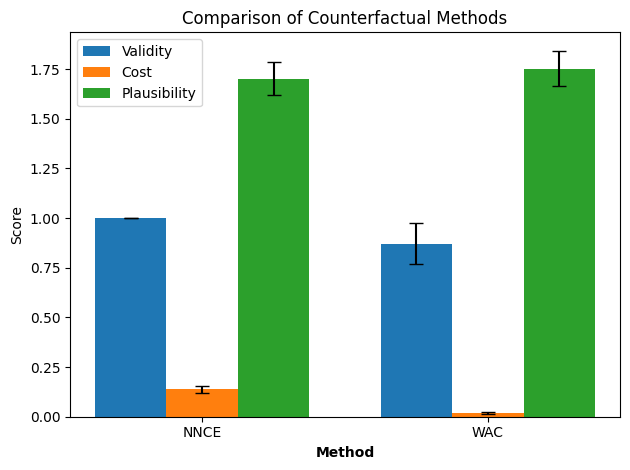

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
methods = ['NNCE', 'WAC']
validity = [1.0, 0.87]
validity_err = [0.0, 0.103]
cost = [0.1379999965429306, 0.017999999225139618]
cost_err = [0.01899999938905239, 0.004999999888241291]
plausibility = [1.7020000219345093, 1.753000020980835]
plausibility_err = [0.08399999886751175, 0.09000000357627869]

# Define positions for the groups
barWidth = 0.25
r1 = np.arange(len(validity))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create the bar plot
plt.bar(r1, validity, width=barWidth, yerr=validity_err, capsize=5, label='Validity')
plt.bar(r2, cost, width=barWidth, yerr=cost_err, capsize=5, label='Cost')
plt.bar(r3, plausibility, width=barWidth, yerr=plausibility_err, capsize=5, label='Plausibility')

# Add labels and title
plt.xlabel('Method', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(validity))], methods)
plt.ylabel('Score')
plt.title('Comparison of Counterfactual Methods')

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


### Performance Differences

**Task 3(e)**: Discuss in your report commenting their performance based on the metrics. Link the findings to their theories.

Validity: indicates if counterfactual explanations shift the model's prediction to the intended class. NNCE achieves perfect validity (1.0), ensuring all its counterfactuals effectively change the prediction outcome. WAC shows slightly lower validity, hinting that some counterfactuals it generates may not achieve the desired change. This could be because WAC's counterfactuals may not be as near the decision boundary as those from NNCE, possibly due to the optimisation in WAC that might settle on local optima or fail to meet all constraints.

Cost: measures how much the input has to be changed to produce the counterfactual. Lower costs are generally preferred as they indicate smaller changes from the original input, which can be more realistic or actionable. NNCE exhibits a marginally higher cost than WAC, suggesting NNCE's counterfactuals entail more significant alterations to the input. Conversely, WAC's lower cost implies it efficiently finds minimal necessary changes for prediction alteration, possibly by targeting an average representation of the desired class, leading to a more central counterfactual. NNCE's approach, limited to selecting existing dataset points, might not always yield the nearest counterfactual, especially in less dense feature space areas.

Plausibility: measures the likelihood of counterfactual instances occurring in reality, with higher scores indicating more realistic counterfactuals. While NNCE theoretically should score better by picking actual data instances, but WAC achieves a higher plausibility score with lower variability. This suggests WAC's method of averaging might avoid outliers, generating counterfactuals more representative of the data domain, unlike NNCE, which could choose more atypical instances, particularly in noisy datasets or around complex decision boundaries.

The differences between NNCE and WAC can be attributed to their underlying theories and implementations:

NNCE: Typically operates by searching for existing instances in the dataset that serve as plausible counterfactuals. This method ensures that counterfactuals are realistic (since they come from real data points) but might lead to higher costs if no close neighbours are of a different class.

WAC: Instead of searching for actual instances, WAC generates new samples by weighting features of instances from the desired class. This can produce more nuanced counterfactuals, leading to lower costs and higher plausibility, as seen in the results.

Findings: The counterintuitive aspect is that that WAC, despite being a method that generates synthetic points, has higher plausibility and lower cost than NNCE, which uses real data points. This could be due to overfitting in the neural network model where NNCE selects outliers or unusual points as counterfactuals (NNCE is limited by the available data distribution and may choose suboptimal points if the dataset is sparse or has noisy regions), whereas WAC, through averaging, avoids outliers and finds more``typical" instances of the desired class.